# **ENGR533 Final Project**

name: Boyuan Zhang

This is a covid-19 prediction neural network. And all my data is from kaggle.

# **Importing Libraries**

This section will import all the dependencies of this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D
from keras.layers import Dense, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import Callback

from PIL import Image
from numpy import asarray
import os
%matplotlib inline

# **Loading Data**

This section is for data loading and all the preparation work for the later training.

In [2]:
def load_image(path, width, h_size):
    image_array = []
    labels = []
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file != []:
                path_updated = os.path.join(subdir, file)
                label = subdir.split("/")[-1]
                labels.append(label)
                img = Image.open(path_updated).convert('L')
                img = img.resize((width, h_size), Image.ANTIALIAS)
                frame = asarray(img)
                image_array.append(frame)
    
    image_array1 = np.zeros(shape=(np.array(image_array).shape[0], h_size, width,  1))
    for i in range(np.array(image_array).shape[0]):
        image_array1[i, :, :, 0] = image_array[i]
    
    return image_array1, np.array(labels)

In [3]:
path = "./Covid19-dataset/train"
path_test = "./Covid19-dataset/test"

image_array, image_labels = load_image(path, 48, 48)
image_array_test, image_labels_test = load_image(path_test, 48, 48)

/var/folders/zl/jtytm40n0dj5cn5h_cf5zb5r0000gn/T/ipykernel_54580/1960911290.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((width, h_size), Image.ANTIALIAS)


In [4]:

def vis_training(hlist, start=1):
    loss = np.concatenate([hlist.history['loss']])
    val_loss = np.concatenate([hlist.history['val_loss']])
    acc = np.concatenate([hlist.history['accuracy']])
    val_acc = np.concatenate([hlist.history['val_accuracy']])
    epoch_range = range(1,len(loss)+1)
    
    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    plt.plot(epoch_range[start-1:], loss[start-1:], label='Training Loss')
    plt.plot(epoch_range[start-1:], val_loss[start-1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epoch_range[start-1:], acc[start-1:], label='Training Accuracy')
    plt.plot(epoch_range[start-1:], val_acc[start-1:], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [5]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False) 



In [6]:
image_labels[image_labels == 'Covid'] = 0
image_labels[image_labels == 'Normal'] = 1
image_labels[image_labels == 'Viral Pneumonia'] = 2

image_labels_test[image_labels_test == 'Covid'] = 0
image_labels_test[image_labels_test == 'Normal'] = 1
image_labels_test[image_labels_test == 'Viral Pneumonia'] = 2
image_labels = image_labels.astype('int')
image_labels_test = image_labels_test.astype('int')

train_gen = datagen.flow(image_array, image_labels)
test_gen = datagen.flow(image_array_test, image_labels_test)

# **Network Design**

This section is the model construction part.

In [7]:
def model_seq():
    
    tf.keras.backend.clear_session()
    model=Sequential()

    model.add(Conv2D(filters=32, kernel_size = (3,3), activation="relu", input_shape=(48, 48, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128,activation="relu"))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(3, activation="softmax"))

    optimiser = tf.keras.optimizers.Adam()
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=optimiser, metrics=["accuracy"])
    print(model.summary())

    return model

# **Termination Strategy**

This is the section that sets the termination strategy. You can modify the terminating accuracy here.

In [8]:
class TerminateOnBaseline(Callback):
    def __init__(self, monitor='val_accuracy', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

callbacks = [
tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',min_lr=0.00001,factor=0.2, patience=1, verbose=1),
TerminateOnBaseline(monitor='val_accuracy', baseline=0.95)]

# **Model training**

This section will train the model.

In [9]:
model_covid = model_seq()

batch_size = 8
train_log = model_covid.fit(
    train_gen,
    validation_data = test_gen,
    epochs=1000,
    batch_size = batch_size,
    callbacks = callbacks
    )

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-05-02 12:07:14.039028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-02 12:07:14.039160: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                        

2022-05-02 12:07:14.509797: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-02 12:07:14.827717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 1.2316 - accuracy: 0.7052

2022-05-02 12:07:19.530246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 5s 264ms/step - loss: 1.2316 - accuracy: 0.7052 - val_loss: 40.0577 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/1000
6/8 [=====================>........] - ETA: 0s - loss: 0.7575 - accuracy: 0.8396
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
8/8 [==============================] - 0s 17ms/step - loss: 0.7253 - accuracy: 0.8367 - val_loss: 29.5466 - val_accuracy: 0.3030 - lr: 0.0010
Epoch 3/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.8809 - accuracy: 0.8367 - val_loss: 22.2855 - val_accuracy: 0.3636 - lr: 2.0000e-04
Epoch 4/1000
6/8 [=====================>........] - ETA: 0s - loss: 0.3628 - accuracy: 0.9010
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
8/8 [==============================] - 0s 17ms/step - loss: 0.4175 - accuracy: 0.8924 - val_loss: 20.9084 - val_accuracy: 0.3333 - lr: 2.0000e-04
Epoch 5/1000
8/8 [==============================] - 0s 16ms/step - l

# **Result**

This section will show the result of this model.

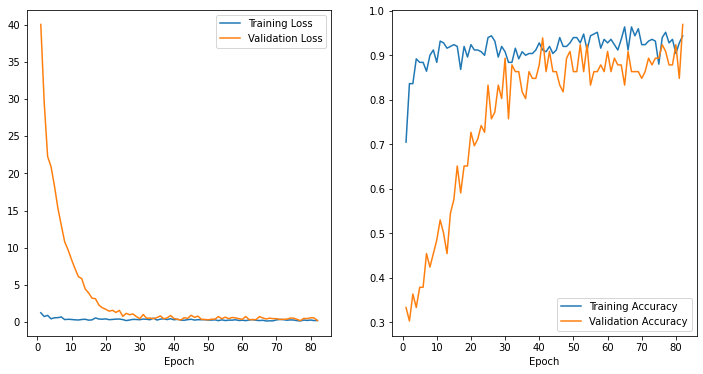

In [10]:
vis_training(train_log, start=1)

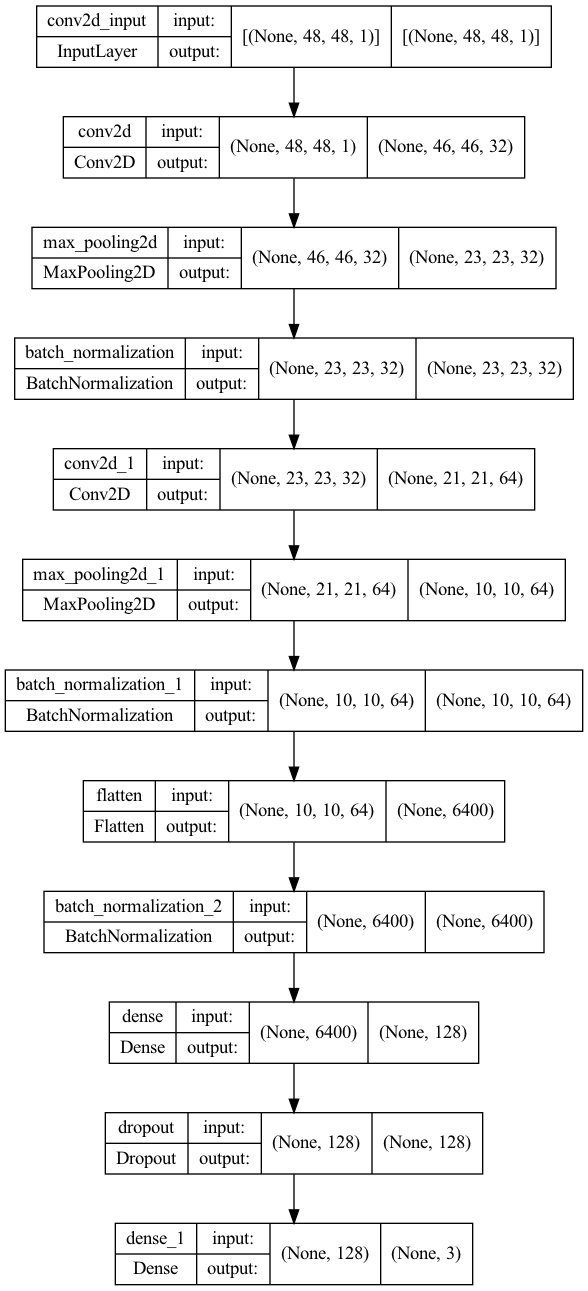

In [11]:
img_file = 'model_2.png'
tf.keras.utils.plot_model(model_covid, to_file=img_file, show_shapes=True)

In [12]:
!jupyter nbconvert --to html 533_project.ipynb 

[NbConvertApp] Converting notebook 534_project.ipynb to html
[NbConvertApp] WARNING | Non-unique cell id '20ccaa01' detected. Corrected to '484ffffc'.
[NbConvertApp] WARNING | Non-unique cell id '5f636694' detected. Corrected to '0ee88191'.
[NbConvertApp] Writing 825893 bytes to 534_project.html
